<div style="background-color:#342184; padding:6px; color:#f3f0ff;">

# Try Finesse 3 
    
## Part IIb: Transfer Functions by 2 Methods

</div>

The goal of this notebook is to show how both `sgen` and `FrequencyResponse` can be used to generate a transfer function.

In [2]:
import finesse
finesse.init_plotting()

We'll start with a kilometer long, detuned cavity:

In [5]:
base = finesse.Model()

base.parse("""
# ifo
l l1
m m1 R=0.9 T=0.1 Rc=-0.7
m m2 R=0.9 T=0.1 Rc=0.7 phi=0.001

link(l1, m1, 1000, m2)
""")

### The `sgen` method

_This method will look more familiar to Finesse 2 users: a signal modulation is introduced, and read out by using a demodulated photodiode. It can be combined with degrees of freedom (`dofs`) to apply modulations to multiple parameters simultaneously. This method can also be used to calculate transfer functions that could not be physically measured, such as the transfer function from a motion into a particular higher order optical mode._

There are four main components when producing a transfer function using a signal generator:

1) `fsig(1)` which is required for a signal simulation and provides a signal frequency `fsig.f` for use in the simulation
2) `sgen` which injects the signal into the provided node
3) `pd1` which can be used to demodulate the signal (`f=fsig.f`) at the provided node
4) `Xaxis` which can be used to sweep the signal frequency (`fsig.f`) across the desired range

**Example:**

Deepcopy the base model and determine the response of the cavity by plotting the transfer function from the motion of the end mirror (`m2.mech.z`) to the transmitted power (`m2.p2.o`) from 10 Hz to 10 kHz.

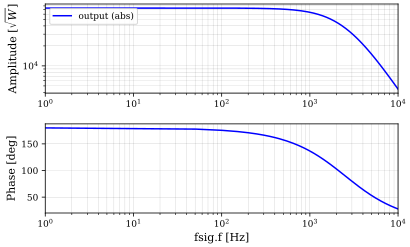

In [7]:
model_sgen = base.deepcopy()

model_sgen.parse("""
# set to signal simulation
fsig(1)

# create a signal generator
sgen sig1 m2.mech.z

# add a detector to demodulate at the signal frequency
pd1 output m2.p2.o f=fsig.f
""")

out = model_sgen.run("xaxis(fsig.f, lin, 1e0, 1e4, 200)")
out.plot(log=True);

### The `FrequencyResponse` method

_`FrequencyResponse` is an optimized version of using `sgen` to create transfer functions. It accepts an array of frequencies to computer the transfer function over (using, e.g., `np.geomspace`), a list of mechanical or electrical nodes to inject the signal, and another list of mechanical or electrical nodes from which to read the output._

There are three main advantages to using `FrequencyResponse` over `sgen`:

1) `FrequencyResponse` is an optimized action which is much faster than using `sgen`
2) `FrequencyResponse` can compute multiple transfer functions by accepting multiple inputs and outputs
3) `FrequencyResponse` does not require the use of `fsig.f`

**Example:**

After creating a deepcopy of the base model, add a DC readout on transmission and use it with the `FrequencyResponse` action to obtain the transfer function from the longitudinal motion of the end mirror (`m2.mech.z`) to the power in transmission.

<Figure size 576x355.968 with 0 Axes>

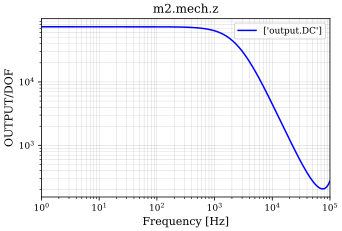

In [9]:
model_fr = base.deepcopy()

model_fr.parse("""
fsig(1)
readout_dc output m2.p2.o
""")

model_fr.run("""
frequency_response(
    geomspace(1e0, 1e5, 200),
    [m2.mech.z],
    [output.DC],
)
""").plot();